# Anime Recommendation Algorithm

This project seeks to create a recommendation system for users to find anime similar to those that they have watched.


The project uses KPrototype and KMeans algorithms to cluster anime datapoints according to several features selected. The final function created takes in a list of anime watched and returns anime which are most similar to those in the list.

Data was taken from https://www.kaggle.com/datasets/andreuvallhernndez/myanimelist?select=anime.csv


Dependencies:

numpy, pandas, matplotlib, sklearn, kmodes, plotnine, lightgbm, shap, scipy

# Loading & Analysis of original data

In [350]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [351]:
data = pd.read_csv('anime.csv')

In [352]:
data

,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,...,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
0,5114,Fullmetal Alchemist: Brotherhood,tv,9.13,1871705,finished_airing,64.0,2009-04-05,2010-07-04,manga,...,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",After a horrific alchemy experiment goes wrong...,NaN,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,['Hagane no Renkinjutsushi: Fullmetal Alchemis...
1,11061,Hunter x Hunter (2011),tv,9.04,1509622,finished_airing,148.0,2011-10-02,2014-09-24,manga,...,"['VAP', 'Nippon Television Network', 'Shueisha']",['VIZ Media'],Hunters devote themselves to accomplishing haz...,NaN,https://cdn.myanimelist.net/images/anime/1337/...,https://myanimelist.net/anime/11061/Hunter_x_H...,https://www.youtube.com/watch?v=D9iTQRB4XRk,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,['HxH (2011)']
2,38524,Shingeki no Kyojin Season 3 Part 2,tv,9.07,1329500,finished_airing,10.0,2019-04-29,2019-07-01,manga,...,"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],Seeking to restore humanity's diminishing hope...,Shingeki no Kyojin adapts content from volumes...,https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[]
3,9253,Steins;Gate,tv,9.08,1252286,finished_airing,24.0,2011-04-06,2011-09-14,visual_novel,...,"['Frontier Works', 'Media Factory', 'Movic', '...",['Funimation'],Eccentric scientist Rintarou Okabe has a never...,Steins;Gate is based on 5pb. and Nitroplus' re...,https://cdn.myanimelist.net/images/anime/5/731...,https://myanimelist.net/anime/9253/Steins_Gate,https://www.youtube.com/watch?v=27OZc-ku6is,Steins;Gate,STEINS;GATE,[]
4,28851,Koe no Katachi,movie,8.95,1398608,finished_airing,1.0,2016-09-17,2016-09-17,manga,...,"['Shochiku', 'Pony Canyon', 'Kodansha', 'ABC A...","['Eleven Arts', 'NYAV Post']","As a wild youth, elementary school student Sho...",Winner of the Excellence Award on the 20th Jap...,https://cdn.myanimelist.net/images/anime/1122/...,https://myanimelist.net/anime/28851/Koe_no_Kat...,https://www.youtube.com/watch?v=XBNWo25izJ8,A Silent Voice,聲の形,['The Shape of Voice']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24160,52470,STARTLINER,music,NaN,0,finished_airing,1.0,2018-07-25,2018-07-25,game,...,[],[],"Music video for the main theme of ONGEKI, ""STA...",NaN,https://cdn.myanimelist.net/images/anime/1911/...,https://myanimelist.net/anime/52470/STARTLINER,NaN,NaN,STARTLINER,[]
24161,52474,Blue Archive: 1.5 Shuunenkinen Short Animation,ona,NaN,0,finished_airing,1.0,2022-07-16,NaN,NaN,...,[],[],NaN,NaN,NaN,https://myanimelist.net/anime/52474/Blue_Archi...,NaN,"Blue Archive ""New Summer Animation PV""",ブルーアーカイブ-Blue Archive-「1.5周年記念ショートアニメーション」,[]
24162,52475,Ryuujin Kappei,ova,NaN,0,finished_airing,1.0,1991-04-21,1991-04-21,original,...,[],[],Kappei got drown into a strange picture book. ...,NaN,https://cdn.myanimelist.net/images/anime/1301/...,https://myanimelist.net/anime/52475/Ryuujin_Ka...,NaN,NaN,龍神カッペイ,[]
24163,52476,Yeongnihan neoguri,NaN,NaN,0,finished_airing,57.0,1988-01-01,2007-01-01,original,...,[],[],Clever Raccoon Dog is a North Korean animated ...,NaN,NaN,https://myanimelist.net/anime/52476/Yeongnihan...,NaN,The Little Bear,령리한 너구리,[]


In [353]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24165 entries, 0 to 24164
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   anime_id          24165 non-null  int64  
 1   title             24165 non-null  object 
 2   type              24092 non-null  object 
 3   score             14272 non-null  float64
 4   scored_by         24165 non-null  int64  
 5   status            24165 non-null  object 
 6   episodes          23397 non-null  float64
 7   start_date        21391 non-null  object 
 8   end_date          19912 non-null  object 
 9   source            20404 non-null  object 
 10  members           24165 non-null  int64  
 11  favorites         24165 non-null  int64  
 12  episode_duration  23302 non-null  object 
 13  total_duration    23002 non-null  object 
 14  rating            23148 non-null  object 
 15  sfw               24165 non-null  bool   
 16  approved          24165 non-null  bool  

In [354]:
#filter out anime that is not_yet_aired as the data is not sufficiently accurate

temp = data[data['status'] != 'not_yet_aired' ]

In [355]:
#retrieve parameters for clustering analysis

relevant = temp[['anime_id','status','type', 'episodes', 'start_year', 'rating', 'source', 'genres', 'themes', 'demographics']]


In [356]:
relevant

,anime_id,status,type,episodes,start_year,rating,source,genres,themes,demographics
0,5114,finished_airing,tv,64.0,2009.0,r,manga,"['Action', 'Adventure', 'Drama', 'Fantasy']",['Military'],['Shounen']
1,11061,finished_airing,tv,148.0,2011.0,pg_13,manga,"['Action', 'Adventure', 'Fantasy']",[],['Shounen']
2,38524,finished_airing,tv,10.0,2019.0,r,manga,"['Action', 'Drama']","['Gore', 'Military', 'Survival']",['Shounen']
3,9253,finished_airing,tv,24.0,2011.0,pg_13,visual_novel,"['Drama', 'Sci-Fi', 'Suspense']","['Psychological', 'Time Travel']",[]
4,28851,finished_airing,movie,1.0,2016.0,pg_13,manga,['Drama'],['Romantic Subtext'],['Shounen']
...,...,...,...,...,...,...,...,...,...,...
24160,52470,finished_airing,music,1.0,NaN,g,game,[],['Music'],[]
24161,52474,finished_airing,ona,1.0,NaN,NaN,NaN,"['Action', 'Fantasy']",['School'],[]
24162,52475,finished_airing,ova,1.0,NaN,NaN,original,"['Action', 'Adventure', 'Fantasy']",[],[]
24163,52476,finished_airing,NaN,57.0,NaN,NaN,original,[],[],['Kids']


In [357]:
relevant.isna().sum()

anime_id           0
status             0
type              11
episodes         312
start_year      5924
rating           782
source          3722
genres             0
themes             0
demographics       0
dtype: int64

In [358]:
#save relevant anime data to file for scrape2.py


#relevant.to_csv('relevant_anime_data.csv', index = False)

# Reloading data after web-scraping

In [10]:
new_data = pd.read_csv('new_anime.csv')

In [11]:
new_data

,anime_id,status,type,episodes,start_year,rating,source,genres,themes,demographics
0,5114,finished_airing,tv,64,2009,r,manga,"['Action', 'Adventure', 'Drama', 'Fantasy']",['Military'],['Shounen']
1,11061,finished_airing,tv,148,2011,pg_13,manga,"['Action', 'Adventure', 'Fantasy']",[],['Shounen']
2,38524,finished_airing,tv,10,2019,r,manga,"['Action', 'Drama']","['Gore', 'Military', 'Survival']",['Shounen']
3,9253,finished_airing,tv,24,2011,pg_13,visual_novel,"['Drama', 'Sci-Fi', 'Suspense']","['Psychological', 'Time Travel']",[]
4,28851,finished_airing,movie,1,2016,pg_13,manga,['Drama'],['Romantic Subtext'],['Shounen']
...,...,...,...,...,...,...,...,...,...,...
23544,52470,finished_airing,music,1,2018,g,game,[],['Music'],[]
23545,52474,finished_airing,ona,1,Error 404,Error 404,Error 404,"['Action', 'Fantasy']",['School'],[]
23546,52475,finished_airing,ova,1,1991,PG-13,original,"['Action', 'Adventure', 'Fantasy']",[],[]
23547,52476,finished_airing,Error 404,57,Error 404,Error 404,original,[],[],['Kids']


In [12]:
def check_nan(value):
    if value in ('?', 'Unknown', 'Error 404'):
        return None
    return value

In [13]:
#Remove data containing Error 404 as they are anime no longer on the website

#Remove data containing '?' or 'Unknown' as these are true NaN values even after web-scraping


for column in ('type', 'episodes', 'start_year', 'source', 'rating'):
    new_data[column] = new_data.apply(lambda row: check_nan(row[column]), axis =1)

In [14]:
new_data = new_data.dropna()

In [15]:
new_data.isna().sum()

anime_id        0
status          0
type            0
episodes        0
start_year      0
rating          0
source          0
genres          0
themes          0
demographics    0
dtype: int64

In [16]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18134 entries, 0 to 23546
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   anime_id      18134 non-null  int64 
 1   status        18134 non-null  object
 2   type          18134 non-null  object
 3   episodes      18134 non-null  object
 4   start_year    18134 non-null  object
 5   rating        18134 non-null  object
 6   source        18134 non-null  object
 7   genres        18134 non-null  object
 8   themes        18134 non-null  object
 9   demographics  18134 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.5+ MB


# Analyzing and cleaning data

In [17]:
print(set(new_data['type']))

#there are 2 types of 'special' due to uppercase-lowercase


print()
print(set(new_data['rating']))


#There are also duplicates of rating due to upper-lower case and PG-13 has a '-' whereas pg_13 has a '_'


print()
print(set(new_data['source']))

#There are duplicates in source due to upper-lower casing as well
#4-koma_manga and 4_koma_manga seem to be the same data

{'music', 'movie', 'Special', 'tv', 'ona', 'special', 'ova'}

{'R', 'r', 'pg', 'PG-13', 'pg_13', 'r+', 'R+', 'PG', 'rx', 'G', 'g'}

{'manga', 'game', 'Visual_novel', 'radio', '4_koma_manga', 'book', 'Novel', 'web_manga', 'Music', 'Picture', 'Other', 'card_game', 'Original', 'novel', 'music', '4-koma_manga', 'Book', 'Manga', 'visual_novel', 'light_novel', 'web_novel', 'mixed_media', 'original', 'other', 'picture_book', 'Game'}


In [18]:
#Changing all elements in 'type', 'rating' and 'source' to lowercase
#changing PG-13 in 'rating' to pg_13

new_data['type'] = new_data.apply(lambda row: row.type.lower(), axis =1)


def change_rating(value):
    if value == 'PG-13':
        return 'pg_13'
    return value.lower()


new_data['rating'] = new_data.apply(lambda row: change_rating(row.rating), axis =1)


def change_source(value):
    if value == '4-koma_manga':
        return '4_koma_manga'
    return value.lower()


new_data['source'] = new_data.apply(lambda row: change_source(row.source), axis =1)


C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\667874610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['type'] = new_data.apply(lambda row: row.type.lower(), axis =1)
C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\667874610.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['rating'] = new_data.apply(lambda row: change_rating(row.rating), axis =1)
C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\667874610.py:22: SettingWithCopyWarning: 
A value is trying to be set on a co

In [19]:
print(set(new_data['type']))

print()
print(set(new_data['rating']))

print()
print(set(new_data['source']))


{'music', 'movie', 'tv', 'ona', 'special', 'ova'}

{'r', 'pg', 'pg_13', 'r+', 'rx', 'g'}

{'novel', 'original', 'manga', 'music', 'game', 'picture', 'card_game', 'radio', 'visual_novel', 'light_novel', '4_koma_manga', 'other', 'web_novel', 'mixed_media', 'book', 'picture_book', 'web_manga'}


In [20]:
print(set(new_data['episodes']))
print()
print (set(new_data['start_year']))


#episodes and start_year are type object even though they are numeric due to the '?' values present before

{'29', '214', '398', '11', '23', '526', '148', '356', '130', '77', '151', '728', '102', '63', '39', '41', '101', '300', '212', '114', '176', '420', '260', '78', '3057', '55', '431', '199', '25', '66', '108', '99', '225', '71', '364', '305', '245', '1000', '56', '237', '272', '144', '3', '45', '10', '93', '79', '418', '57', '320', '145', '331', '220', '178', '59', '608', '195', '694', '230', '67', '76', '1274', '142', '180', '380', '125', '156', '104', '27', '146', '35', '32', '100', '150', '215', '50', '40', '136', '37', '30', '193', '70', '61', '161', '105', '263', '210', '86', '358', '84', '47', '400', '312', '1', '82', '182', '216', '499', '9', '83', '283', '276', '14', '117', '48', '74', '200', '1787', '280', '175', '95', '127', '240', '115', '258', '21', '167', '800', '87', '89', '5', '164', '291', '34', '65', '153', '88', '120', '51', '192', '53', '373', '15', '135', '154', '330', '113', '201', '31', '17', '155', '110', '296', '294', '128', '49', '365', '1818', '229', '119', '124

In [21]:
new_data['episodes'] = pd.to_numeric(new_data['episodes'])


new_data['start_year'] = pd.to_numeric(new_data['start_year'])


C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\943856671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['episodes'] = pd.to_numeric(new_data['episodes'])
C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\943856671.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['start_year'] = pd.to_numeric(new_data['start_year'])


In [22]:
print(set(new_data['episodes']))
print()
print (set(new_data['start_year']))

#Now they are numeric which is more appropriate for clustering analysis

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 526, 87, 89, 88, 91, 92, 93, 94, 95, 96, 97, 90, 99, 100, 101, 102, 103, 104, 105, 98, 108, 109, 110, 111, 112, 113, 114, 115, 624, 117, 119, 120, 122, 124, 125, 126, 127, 128, 130, 131, 132, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 150, 151, 153, 154, 155, 156, 160, 161, 164, 167, 170, 172, 175, 176, 178, 180, 694, 182, 191, 192, 193, 195, 199, 200, 201, 203, 208, 210, 212, 214, 726, 215, 728, 216, 220, 224, 225, 229, 230, 744, 237, 240, 243, 245, 1274, 1787, 258, 260, 263, 272, 276, 280, 1818, 283, 800, 291, 293, 294, 296, 300, 302, 305, 309, 312, 320, 330, 331, 356, 358, 364, 365, 366, 373, 380, 398, 400, 418, 420, 431, 1000, 3057, 4

In [23]:
print("\n".join(sorted(list(set(new_data['themes'])))))

#Each data point(anime) can have more than one theme
#An anime can also have no themes

['Adult Cast', 'Detective', 'Gag Humor']
['Adult Cast', 'Detective', 'Gore', 'Mecha', 'Psychological']
['Adult Cast', 'Detective', 'Mecha', 'Military', 'Psychological']
['Adult Cast', 'Detective', 'Mecha', 'Military']
['Adult Cast', 'Detective', 'Mecha', 'Psychological']
['Adult Cast', 'Detective', 'Military', 'Psychological']
['Adult Cast', 'Detective', 'Military']
['Adult Cast', 'Detective', 'Psychological']
['Adult Cast', 'Detective', 'Workplace']
['Adult Cast', 'Detective']
['Adult Cast', 'Gag Humor', 'Showbiz', 'Workplace']
['Adult Cast', 'Gag Humor']
['Adult Cast', 'Gore', 'Military', 'Super Power', 'Vampire']
['Adult Cast', 'Gore', 'Military', 'Vampire']
['Adult Cast', 'Gore', 'Organized Crime', 'Super Power']
['Adult Cast', 'Gore', 'Vampire']
['Adult Cast', 'High Stakes Game', 'Organized Crime', 'Psychological', 'Strategy Game']
['Adult Cast', 'High Stakes Game', 'Psychological', 'Strategy Game']
['Adult Cast', 'High Stakes Game', 'Psychological']
['Adult Cast', 'Historical', '

In [24]:
print("\n".join(list(set(new_data['demographics']))))

#Each data point(anime) can have more than one demographic
#An anime can also have no demographics

['Shoujo']
['Kids', 'Seinen']
['Josei']
['Seinen']
['Kids', 'Shounen']
['Kids', 'Shoujo']
['Josei', 'Shoujo']
['Kids']
['Kids', 'Seinen', 'Shoujo']
[]
['Shounen']


In [25]:
print("\n".join(sorted(list(set(new_data['genres'])))))

#Each data point(anime) can have more than one demographic
#An anime can also have no genres

['Action', 'Adventure', 'Avant Garde', 'Mystery', 'Supernatural']
['Action', 'Adventure', 'Boys Love', 'Fantasy', 'Mystery', 'Supernatural']
['Action', 'Adventure', 'Comedy', 'Drama', 'Ecchi', 'Fantasy', 'Romance']
['Action', 'Adventure', 'Comedy', 'Drama', 'Ecchi', 'Horror', 'Mystery', 'Romance', 'Sci-Fi']
['Action', 'Adventure', 'Comedy', 'Drama', 'Ecchi', 'Romance', 'Sci-Fi']
['Action', 'Adventure', 'Comedy', 'Drama', 'Fantasy', 'Romance', 'Supernatural']
['Action', 'Adventure', 'Comedy', 'Drama', 'Fantasy']
['Action', 'Adventure', 'Comedy', 'Drama', 'Mystery']
['Action', 'Adventure', 'Comedy', 'Drama', 'Romance', 'Sci-Fi']
['Action', 'Adventure', 'Comedy', 'Drama', 'Romance']
['Action', 'Adventure', 'Comedy', 'Drama', 'Sci-Fi', 'Sports']
['Action', 'Adventure', 'Comedy', 'Drama', 'Sci-Fi']
['Action', 'Adventure', 'Comedy', 'Drama', 'Supernatural']
['Action', 'Adventure', 'Comedy', 'Drama']
['Action', 'Adventure', 'Comedy', 'Ecchi', 'Fantasy', 'Romance']
['Action', 'Adventure', 'Com

In [26]:
def check_contains(string, value2compare):
    values = transform_to_list(string)
    
    if value2compare in values:
        return 1
    return 0

In [27]:
#get all possible values in demographics, themes and genres

def transform_to_list(string):
    for x in "['] ":
        string = string.replace(x,'')
    return string.split(',')


possible_values = {'demographics': [], 'themes':[], 'genres':[]}

for x in ('demographics', 'themes', 'genres'):
    for strings in new_data[x]:
        if strings == '[]':
            continue

        temp = transform_to_list(strings)


        for value in temp:
            if value not in possible_values[x]:
                possible_values[x].append(value)


In [28]:

for x in possible_values['demographics']:
    new_data[x] = new_data.apply(lambda row: check_contains(row.demographics, x), axis =1)

    
for x in possible_values['genres']:
    new_data[x] = new_data.apply(lambda row: check_contains(row.genres, x), axis =1)
    
    
    
for x in possible_values['themes']:
    new_data[x] = new_data.apply(lambda row: check_contains(row.themes, x), axis =1)

C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\2017997754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[x] = new_data.apply(lambda row: check_contains(row.demographics, x), axis =1)
C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\2017997754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[x] = new_data.apply(lambda row: check_contains(row.demographics, x), axis =1)
C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\2017997754.py:2: SettingWithCopyWarning: 
A value is trying

C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\2017997754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[x] = new_data.apply(lambda row: check_contains(row.genres, x), axis =1)
C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\2017997754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[x] = new_data.apply(lambda row: check_contains(row.genres, x), axis =1)
C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\2017997754.py:6: SettingWithCopyWarning: 
A value is trying to be set o

C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\2017997754.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[x] = new_data.apply(lambda row: check_contains(row.themes, x), axis =1)
C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\2017997754.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[x] = new_data.apply(lambda row: check_contains(row.themes, x), axis =1)
C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\2017997754.py:11: SettingWithCopyWarning: 
A value is trying to be se

C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\2017997754.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[x] = new_data.apply(lambda row: check_contains(row.themes, x), axis =1)
C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\2017997754.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[x] = new_data.apply(lambda row: check_contains(row.themes, x), axis =1)
C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\2017997754.py:11: SettingWithCopyWarning: 
A value is trying to be se

In [29]:
new_data

,anime_id,status,type,episodes,start_year,rating,source,genres,themes,demographics,...,Harem,VideoGame,Racing,PerformingArts,Idols(Female),Educational,Medical,MagicalSexShift,Pets,Idols(Male)
0,5114,finished_airing,tv,64,2009,r,manga,"['Action', 'Adventure', 'Drama', 'Fantasy']",['Military'],['Shounen'],...,0,0,0,0,0,0,0,0,0,0
1,11061,finished_airing,tv,148,2011,pg_13,manga,"['Action', 'Adventure', 'Fantasy']",[],['Shounen'],...,0,0,0,0,0,0,0,0,0,0
2,38524,finished_airing,tv,10,2019,r,manga,"['Action', 'Drama']","['Gore', 'Military', 'Survival']",['Shounen'],...,0,0,0,0,0,0,0,0,0,0
3,9253,finished_airing,tv,24,2011,pg_13,visual_novel,"['Drama', 'Sci-Fi', 'Suspense']","['Psychological', 'Time Travel']",[],...,0,0,0,0,0,0,0,0,0,0
4,28851,finished_airing,movie,1,2016,pg_13,manga,['Drama'],['Romantic Subtext'],['Shounen'],...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23539,52450,finished_airing,movie,1,2017,r,original,['Avant Garde'],['Psychological'],[],...,0,0,0,0,0,0,0,0,0,0
23541,52453,finished_airing,music,1,2019,g,original,[],[],['Kids'],...,0,0,0,0,0,0,0,0,0,0
23542,52454,finished_airing,music,1,2022,pg_13,mixed_media,['Fantasy'],['Idols (Female)'],[],...,0,0,0,0,1,0,0,0,0,0
23544,52470,finished_airing,music,1,2018,g,game,[],['Music'],[],...,0,0,0,0,0,0,0,0,0,0


In [32]:
#saving clean data

new_data.to_csv('clean.csv', index = False)

# Clustering Analysis with KPrototypes

In [30]:
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import plotnine
from plotnine import *

In [31]:
clean_data = pd.read_csv('clean.csv', index_col = 'anime_id')

In [32]:
relevant_fields = [x for x in clean_data.columns if x not in ('genres', 'demographics', 'themes')]

relevant = clean_data[relevant_fields]

In [33]:
relevant

,status,type,episodes,start_year,rating,source,Shounen,Seinen,Shoujo,Josei,...,Harem,VideoGame,Racing,PerformingArts,Idols(Female),Educational,Medical,MagicalSexShift,Pets,Idols(Male)
anime_id,,,,,,,,,,,,,,,,,,,,,
5114,finished_airing,tv,64,2009,r,manga,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11061,finished_airing,tv,148,2011,pg_13,manga,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38524,finished_airing,tv,10,2019,r,manga,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9253,finished_airing,tv,24,2011,pg_13,visual_novel,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28851,finished_airing,movie,1,2016,pg_13,manga,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52450,finished_airing,movie,1,2017,r,original,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52453,finished_airing,music,1,2019,g,original,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52454,finished_airing,music,1,2022,pg_13,mixed_media,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [34]:
relevant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18134 entries, 5114 to 52475
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   status           18134 non-null  object
 1   type             18134 non-null  object
 2   episodes         18134 non-null  int64 
 3   start_year       18134 non-null  int64 
 4   rating           18134 non-null  object
 5   source           18134 non-null  object
 6   Shounen          18134 non-null  int64 
 7   Seinen           18134 non-null  int64 
 8   Shoujo           18134 non-null  int64 
 9   Josei            18134 non-null  int64 
 10  Kids             18134 non-null  int64 
 11  Action           18134 non-null  int64 
 12  Adventure        18134 non-null  int64 
 13  Drama            18134 non-null  int64 
 14  Fantasy          18134 non-null  int64 
 15  Sci-Fi           18134 non-null  int64 
 16  Suspense         18134 non-null  int64 
 17  Supernatural     18134 non-n

In [33]:
#identify categorical and numerical variables. 

#Each variable for demographics, themes and genres can represent 2 categories - "is" and "is not"

categorical = relevant[[x for x in relevant.columns if x not in ('episodes', 'start')]]

numerical = relevant[['episodes', 'start_year']]

In [34]:
#obtain index of categorical variables


categoricalPos = [relevant.columns.get_loc(col) for col in list(categorical.columns)]

In [35]:
scaler = MinMaxScaler()

for c in numerical.columns:
    scaler.fit(np.array(relevant[c]).reshape(-1, 1))
    relevant[c] =  scaler.transform(np.array(relevant[c]).reshape(-1, 1))

C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\1930150311.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\1930150311.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
relevant_np = relevant.to_numpy()

In [37]:
relevant

,status,type,episodes,start_year,rating,source,Shounen,Seinen,Shoujo,Josei,...,Harem,VideoGame,Racing,PerformingArts,Idols(Female),Educational,Medical,MagicalSexShift,Pets,Idols(Male)
anime_id,,,,,,,,,,,,,,,,,,,,,
5114,finished_airing,tv,0.020615,0.876190,r,manga,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11061,finished_airing,tv,0.048102,0.895238,pg_13,manga,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38524,finished_airing,tv,0.002945,0.971429,r,manga,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9253,finished_airing,tv,0.007526,0.895238,pg_13,visual_novel,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28851,finished_airing,movie,0.000000,0.942857,pg_13,manga,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52450,finished_airing,movie,0.000000,0.952381,r,original,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52453,finished_airing,music,0.000000,0.971429,g,original,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52454,finished_airing,music,0.000000,1.000000,pg_13,mixed_media,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Visualizing Data

C:\Users\Anakin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
C:\Users\Anakin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
C:\Users\Anakin\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
C:\Users\Anakin\AppData\Local\Temp\ipykernel_20944\2612891763.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


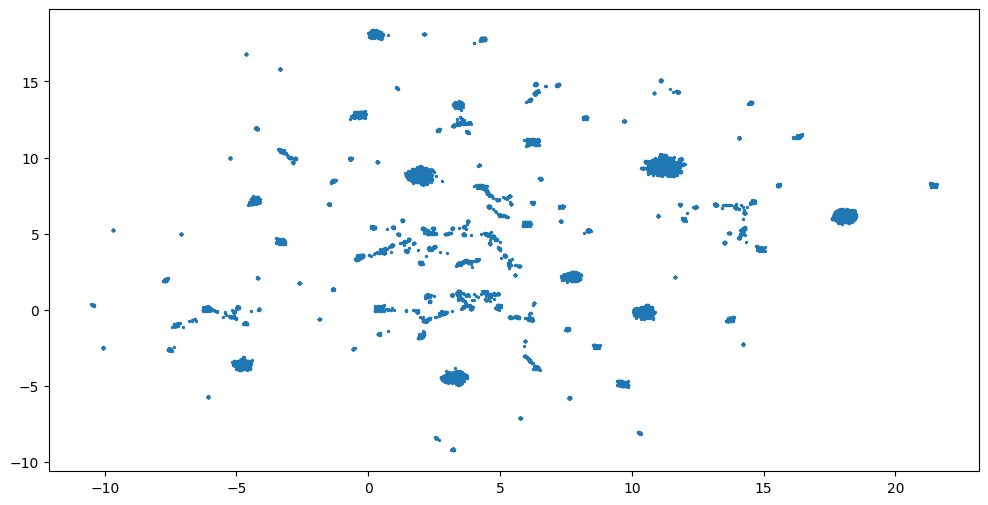

In [38]:
import umap.umap_ as umap


##preprocessing categorical
categorical = relevant.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later

n_data_types = len(relevant.select_dtypes(include='object').columns) + len(['themes', 'demographics', 'genres']) + len(numerical.columns)


categorical_weight = (n_data_types - len(numerical.columns)) / n_data_types

#Embedding numerical & categorical
fit1 = umap.UMAP().fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

#Augmenting the numerical embedding with categorical
intersection = umap.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.reset_local_connectivity(intersection)
embedding = umap.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False, False, None)

plt.figure(figsize=(12, 6))
plt.scatter(*embedding[0].T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

#There seems to be about 7-8 clusters 

# Optimizing clusters with Elbow Method

In [40]:
cost = []
for cluster in range(1, 12):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(relevant_np, categorical = categoricalPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        print(f"Can't cluster with {cluster} clusters")
        break


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Cluster initiation: 10
Cluster initiation: 11


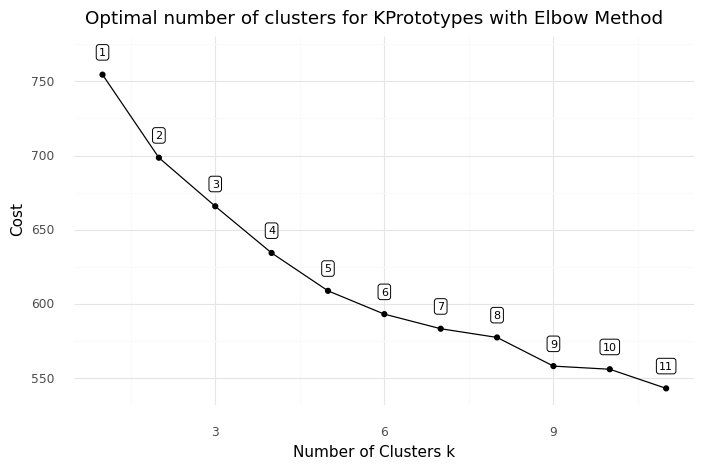

<ggplot: (139261881146)>

In [41]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 12), 'Cost':cost})


df_cost
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 8,
               nudge_y = 15) +
    labs(title = 'Optimal number of clusters for KPrototypes with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
    
)

# Visualizing and analyzing Kprototype cluster

In [43]:
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
import shap
from sklearn.decomposition import PCA

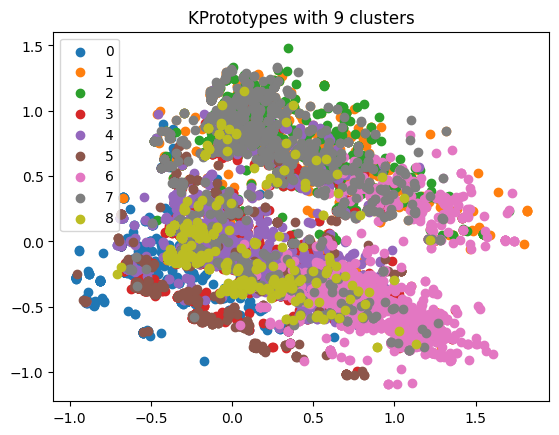

In [44]:
pca = PCA(2)

df = pca.fit_transform(relevant.select_dtypes(exclude = 'object'))


kprototype =  KPrototypes(n_jobs = -1, n_clusters = 9, init = 'Huang', random_state = 0)

clusters = kprototype.fit_predict(relevant_np, categorical = categoricalPos)

u_labels = np.unique(clusters)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[clusters == i , 0] , df[clusters == i , 1] , label = i)
plt.legend()

plt.title('KPrototypes with 9 clusters')
plt.show()


In [45]:
lgbm_data = relevant.copy()

for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')


clf_kp = LGBMClassifier()
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, clusters, scoring='f1_weighted')
print('Accuracy of K-Prototypes clusters is {:.2f}%'.format(np.mean(cv_scores_kp)*100))

Accuracy of K-Prototypes clusters is 97.07%


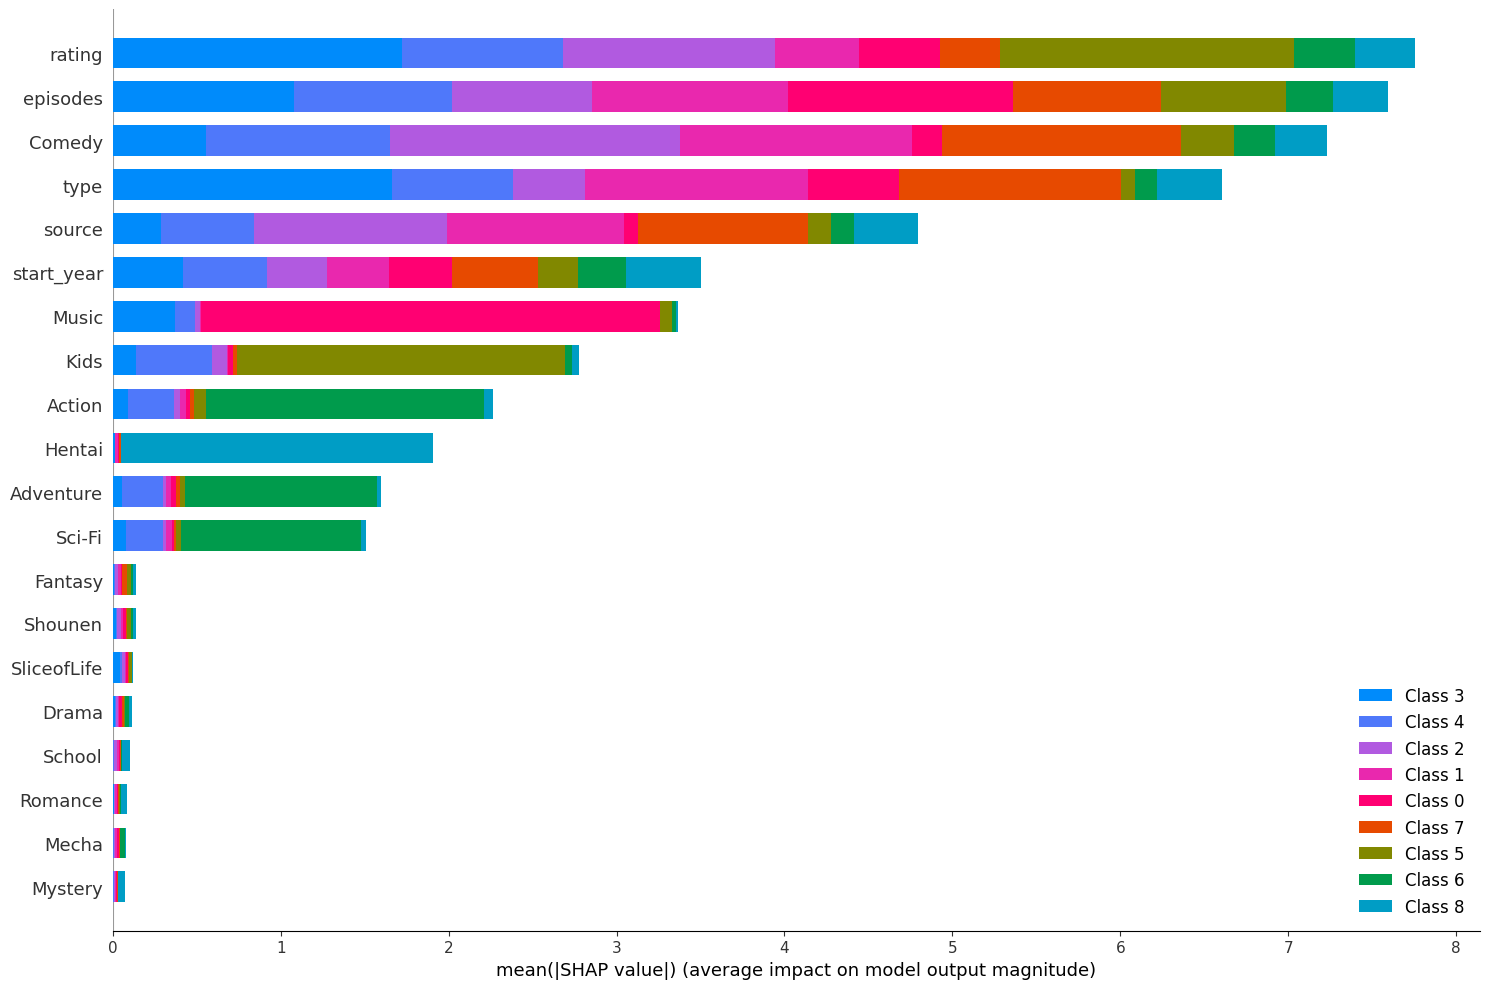

In [46]:
#Fit the model
clf_kp.fit(lgbm_data, clusters)

#SHAP values
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(15, 10))

# Clustering Analysis with KMeans

In [62]:
from sklearn.cluster import KMeans


In [63]:
clean_data = pd.read_csv('clean.csv', index_col = 'anime_id')

kmean_data = clean_data[relevant_fields]

In [64]:
#identify categorical and numerical variables.

#As themes, demographics and genres were already transformed to binary variables, no transformation is necessary for them

categorical = kmean_data[['rating', 'status', 'source', 'type']]

numerical = kmean_data[['episodes', 'start_year']]


others = kmean_data[[x for x in list(kmean_data.columns) if x not in ('episodes', 'start_year','rating', 'status', 'source', 'type' )]]

In [65]:
scaler = MinMaxScaler()

numerical_data = kmean_data[numerical.columns]


for c in numerical.columns:
    scaler.fit(np.array(kmean_data[c]).reshape(-1, 1))
    numerical_data[c] =  scaler.transform(np.array(kmean_data[c]).reshape(-1, 1))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [66]:
categorical_data= pd.get_dummies(categorical)

In [67]:

kmean_data = pd.concat([numerical_data,categorical_data, others], axis =1)

In [68]:
kmean_data

,episodes,start_year,rating_g,rating_pg,rating_pg_13,rating_r,rating_r+,rating_rx,status_currently_airing,status_finished_airing,...,Harem,VideoGame,Racing,PerformingArts,Idols(Female),Educational,Medical,MagicalSexShift,Pets,Idols(Male)
anime_id,,,,,,,,,,,,,,,,,,,,,
5114,0.020615,0.876190,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11061,0.048102,0.895238,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
38524,0.002945,0.971429,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9253,0.007526,0.895238,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
28851,0.000000,0.942857,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52450,0.000000,0.952381,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52453,0.000000,0.971429,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52454,0.000000,1.000000,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [69]:
cost = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state = 0).fit(kmean_data)
    cost.append(kmeans.inertia_) # Inertia: Sum of distances of samples to their closest cluster center

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

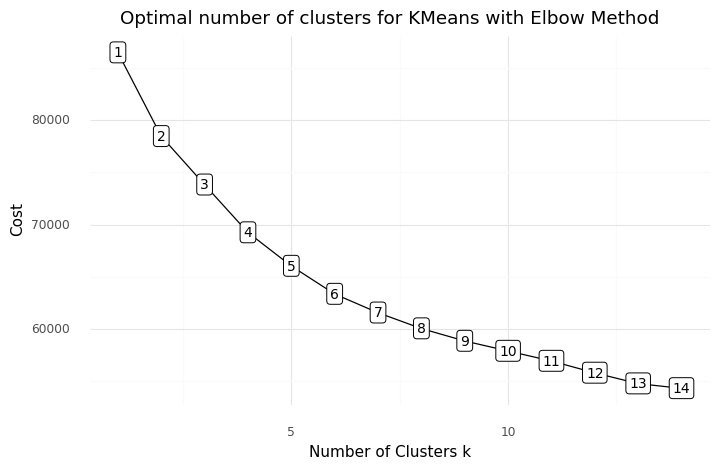

<ggplot: (139268253474)>

In [70]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 15), 'Cost':cost})


df_cost
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 20) +
    labs(title = 'Optimal number of clusters for KMeans with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
    
)

# Visualizing and analyzing Kmeans cluster

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


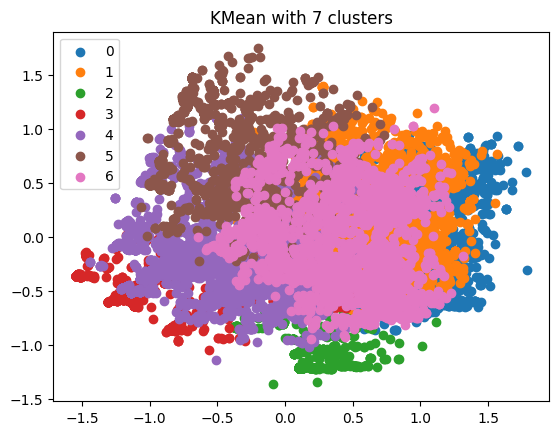

In [81]:
#Try 7 clusters

pca = PCA(2)

df = pca.fit_transform(kmean_data.select_dtypes(exclude = 'object'))


kmean_7 = KMeans(n_clusters = 7, random_state = 0).fit(kmean_data)

clusters = kmean_7.fit_predict(kmean_data)

u_labels = np.unique(clusters)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[clusters == i , 0] , df[clusters == i , 1] , label = i)
plt.legend()

plt.title('KMean with 7 clusters')
plt.show()


In [83]:
lgbm_data = kmean_data.copy()

for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')


clf_kp = LGBMClassifier()
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, clusters, scoring='f1_weighted')
print('Accuracy of K-Means with 7 clusters is {:.2f}%'.format(np.mean(cv_scores_kp)*100))

Accuracy of K-Means with 7 clusters is 98.48%


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


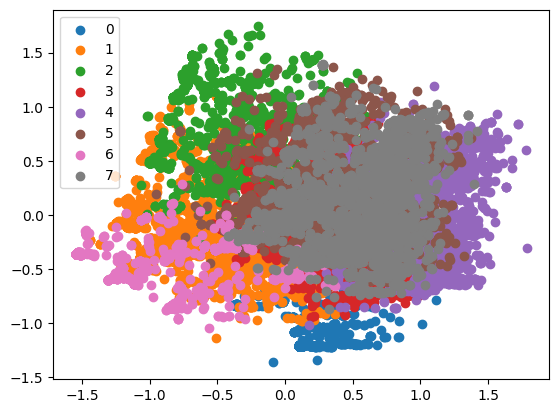

In [84]:
#Try 8 clusters

kmean_8 = KMeans(n_clusters = 8, random_state = 0).fit(kmean_data)

clusters = kmean_8.fit_predict(kmean_data)

pca = PCA(2)

df = pca.fit_transform(kmean_data.select_dtypes(exclude = 'object'))

u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()


In [85]:
lgbm_data = kmean_data.copy()

for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')


clf_km = LGBMClassifier()
cv_scores_kp = cross_val_score(clf_km, lgbm_data, clusters, scoring='f1_weighted')
print('Accuracy of K-Means with 8 clusters is {:.2f}%'.format(np.mean(cv_scores_kp)*100))

Accuracy of K-Means with 8 clusters is 98.42%


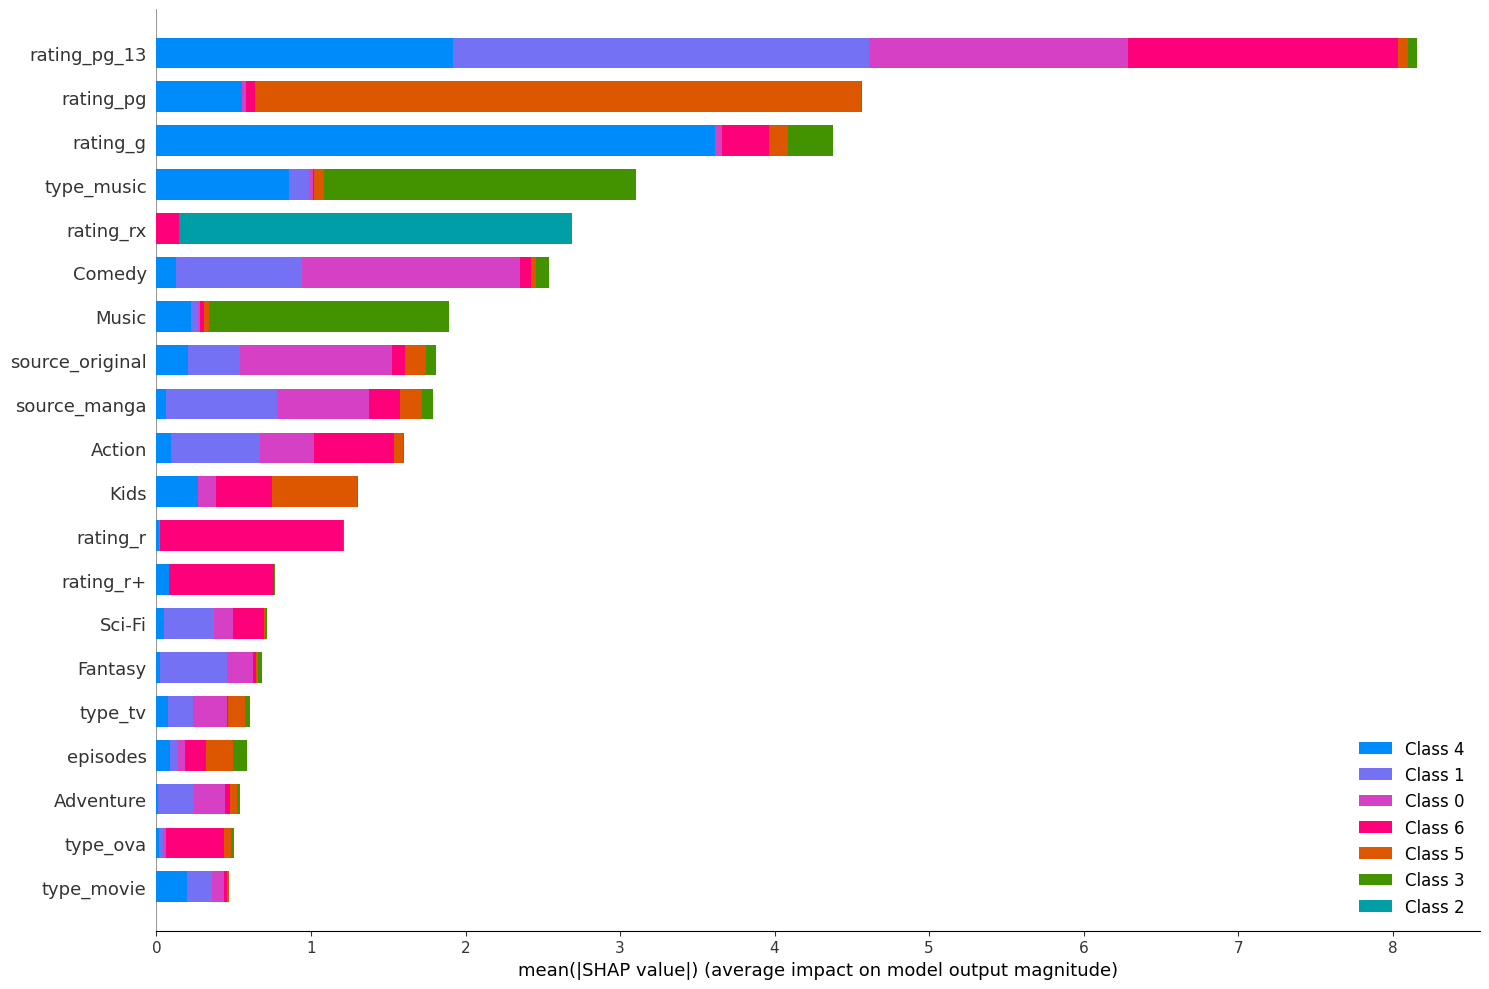

In [86]:
#Fit the model
clf_km.fit(lgbm_data, kmean_7.labels_)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(lgbm_data)
shap.summary_plot(shap_values_km, lgbm_data, plot_type="bar", plot_size=(15, 10))

# Saving kmeans data to file

In [87]:
data = pd.read_csv('anime.csv', index_col = 'anime_id')

temp = pd.concat([data['title'], kmean_data], axis =1)

kmean_data = temp.dropna()


kmean_data

,title,episodes,start_year,rating_g,rating_pg,rating_pg_13,rating_r,rating_r+,rating_rx,status_currently_airing,...,Harem,VideoGame,Racing,PerformingArts,Idols(Female),Educational,Medical,MagicalSexShift,Pets,Idols(Male)
anime_id,,,,,,,,,,,,,,,,,,,,,
5114,Fullmetal Alchemist: Brotherhood,0.020615,0.876190,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11061,Hunter x Hunter (2011),0.048102,0.895238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38524,Shingeki no Kyojin Season 3 Part 2,0.002945,0.971429,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9253,Steins;Gate,0.007526,0.895238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28851,Koe no Katachi,0.000000,0.942857,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52450,Ningyo no Uta,0.000000,0.952381,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52453,Koumori Bat wa Good na Shinshi,0.000000,0.971429,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52454,UnAlive,0.000000,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [88]:
temp#saving kmean_data into file

kmean_data.to_csv('kmean.csv')

# Creating Recommendation system

In [347]:
import pandas as pd
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import MinMaxScaler


def get_anime_data(anime, anime_data):
    """Returns the data of a particular anime from the dataframe"""
    try:
        data = anime_data.select_dtypes(exclude = 'object').loc[anime]
        return data
    
    except (KeyError, ValueError):
        return 
        

def get_mean_vector (anime_data, anime_list):
    """Checks if anime watched is valid and finds them in the dataframe"""
    vectors = []
    for anime_id in anime_list:
                                  
        datapoint = get_anime_data(anime_id, anime_data)
        if datapoint is None:
            print('Warning: {} is an invalid anime id'.format(anime_id))
            continue
        vector = datapoint.values
        vectors.append(vector)  
    
    matrix = np.array(list(vectors))

    return np.mean(matrix, axis=0)




def find_anime(scaler ,anime_data, anime_watched, n_anime, test):
    """Gets the centre of the animes watched and returns the closest animes to that point that the user has not watched"""
    anime_list = []
    
    for anime in anime_watched:
        try:
            anime_id = int(anime)
            anime_list.append(anime_id)
        except ValueError:
            anime_id = anime_data[anime_data['title'] == anime].index
            if len(anime_id) == 0:
                print('Warning: {} is an invalid anime id'.format(anime))
                continue
            else:
                anime_id = anime_id[0]
                anime_list.append(anime_id)
                
    
    anime_center = get_mean_vector(anime_data, anime_list)
    data = anime_data.drop('title', axis =1)                              
    scaled_data = scaler.transform(data)
    scaled_center = scaler.transform(anime_center.reshape(1, -1))
    distances = cdist(scaled_center, scaled_data, 'cosine')
    
    index = list(np.argsort(distances)[0][:n_anime]) #This index is not the same as anime_id
    if test:
        return anime_data.iloc[index]
    
    duplicates = 0
    temp = index.copy()
    for x in temp:
        if anime_data.iloc[x].name in anime_list:
            index.remove(x)
            index.append(np.argsort(distances)[0][n_anime + duplicates + 1])
            duplicates += 1
        
    return anime_data.iloc[index]

In [348]:

def recommend_anime(anime_watched, n_anime=5, test=False):
    anime_data = pd.read_csv('kmean.csv', index_col = 'anime_id')
    scaler = Pipeline([('scaler', MinMaxScaler()), ('kmeans', KMeans(n_clusters=7))]).steps[0][1]
    scaler.fit(anime_data.select_dtypes(exclude = 'object'))
    return find_anime(scaler, anime_data, anime_watched, n_anime, test)

In [349]:
def test_model():
    """Asserts accuracy of the model"""
    assert recommend_anime([345], 1).index[0] != 345
    assert recommend_anime([345], 1, True).index[0] == 345
    
    assert recommend_anime(['Naruto'],1,True)['title'].values[0] == 'Naruto'
    
test_model()

X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names
